# Model Performance Analysis

This notebook visualizes the performance of the **Email Phishing Detection Model** and the **URL Phishing Detection Model**.

## Visualizations Included:
1.  **Confusion Matrix**: Shows True Positives, False Positives, etc.
2.  **ROC Curve**: Shows the trade-off between True Positive Rate and False Positive Rate.
3.  **Feature Importance** (Email Model only): Shows which words/characters contribute most to the phishing decision.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay

%matplotlib inline

## 1. specific Email Phishing Model Analysis

In [3]:
# Load Data
try:
    email_data = pd.read_csv('spambase.data', header=None)
    X_email = email_data.iloc[:, :-1]
    y_email = email_data.iloc[:, -1]
    
    # Split - MUST use same seed as training for consistent overlap, 
    # but ideally we want to see performance on Test set.
    X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
        X_email, y_email, test_size=0.2, random_state=42, stratify=y_email
    )
    
    print(f"Email Test Set Size: {X_test_e.shape}")
except FileNotFoundError:
    print("Error: 'spambase.data' not found.")

# Load Model
try:
    email_model = joblib.load('email_phishing_model.joblib')
    print("Email Model Loaded Successfully")
except FileNotFoundError:
    print("Error: 'email_phishing_model.joblib' not found.")

Email Test Set Size: (921, 57)
Email Model Loaded Successfully


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.7.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.7.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


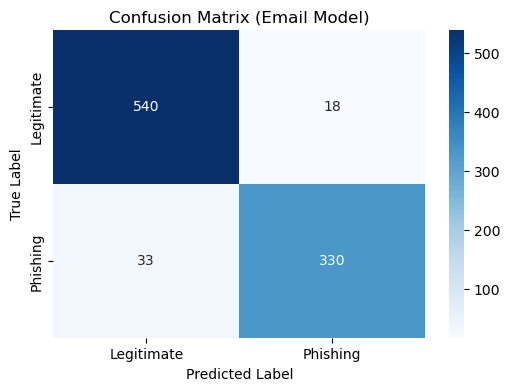

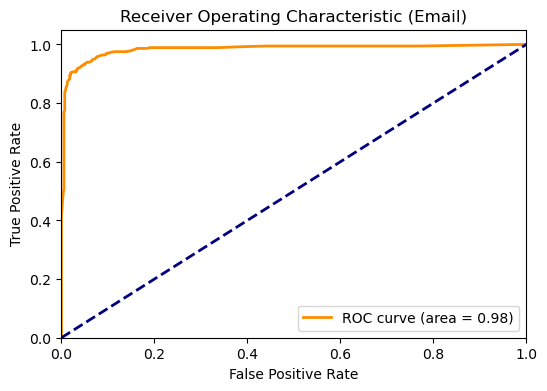

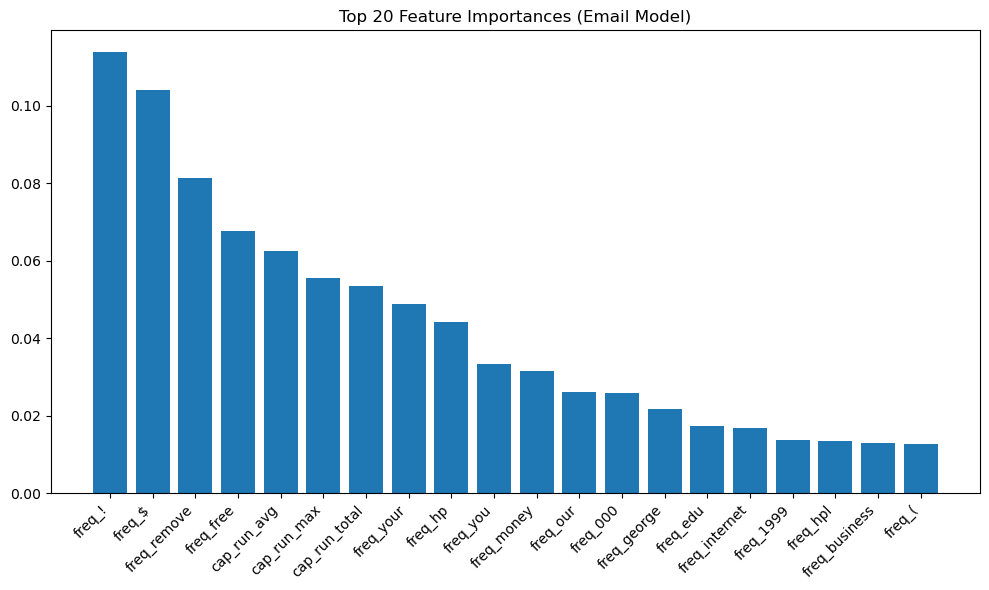

In [4]:
# Predictions
if 'email_model' in locals() and 'X_test_e' in locals():
    y_pred_e = email_model.predict(X_test_e)
    y_prob_e = email_model.predict_proba(X_test_e)[:, 1]

    # 1. Confusion Matrix
    cm_e = confusion_matrix(y_test_e, y_pred_e)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_e, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Legitimate', 'Phishing'], 
                yticklabels=['Legitimate', 'Phishing'])
    plt.title('Confusion Matrix (Email Model)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test_e, y_prob_e)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (Email)')
    plt.legend(loc="lower right")
    plt.show()

    # 3. Feature Importance
    # Define feature names based on spambase documentation
    MH_WORDS = [
        "make", "address", "all", "3d", "our", "over", "remove", "internet",
        "order", "mail", "receive", "will", "people", "report", "addresses",
        "free", "business", "email", "you", "credit", "your", "font", "000",
        "money", "hp", "hpl", "george", "650", "lab", "labs", "telnet", "857",
        "data", "415", "85", "technology", "1999", "parts", "pm", "direct",
        "cs", "meeting", "original", "project", "re", "edu", "table", "conference"
    ]
    MH_CHARS = [";", "(", "[", "!", "$", "#"]
    
    feature_names = [
        *[f"freq_{w}" for w in MH_WORDS],
        *[f"freq_{c}" for c in MH_CHARS],
        "cap_run_avg", "cap_run_max", "cap_run_total"
    ]
    
    importances = email_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Plot top 20
    plt.figure(figsize=(10, 6))
    plt.title("Top 20 Feature Importances (Email Model)")
    plt.bar(range(20), importances[indices[:20]], align="center")
    plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 2. URL Phishing Model Analysis

In [5]:
# Load Data (Using a sample if file is too large to load quickly for vis, 
# but standard load is fine for 30MB)
try:
    url_df = pd.read_csv("phishing_site_urls.csv")
    
    # Fallback logic for column names from training script
    if 'URL' in url_df.columns and 'Label' in url_df.columns:
        X_url = url_df['URL']
        y_url = url_df['Label']
    else:
        # Attempt to find columns
        url_col = next((col for col in url_df.columns if 'url' in col.lower()), None)
        label_col = next((col for col in url_df.columns if 'label' in col.lower() or 'type' in col.lower()), None)
        X_url = url_df[url_col]
        y_url = url_df[label_col]

    # Split
    X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(
        X_url, y_url, test_size=0.2, random_state=42, stratify=y_url
    )
    print(f"URL Test Set Size: {X_test_u.shape}")
except FileNotFoundError:
    print("Error: 'phishing_site_urls.csv' not found.")

# Load Model & Vectorizer
try:
    url_model = joblib.load('url_model.joblib')
    url_vectorizer = joblib.load('url_vectorizer.joblib')
    print("URL Model & Vectorizer Loaded Successfully")
except FileNotFoundError:
    print("Error: URL model files not found.")

URL Test Set Size: (109870,)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.7.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.7.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


URL Model & Vectorizer Loaded Successfully


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.7.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Vectorizing test set (this may take a few seconds)...
Labels found: ['bad', 'good']


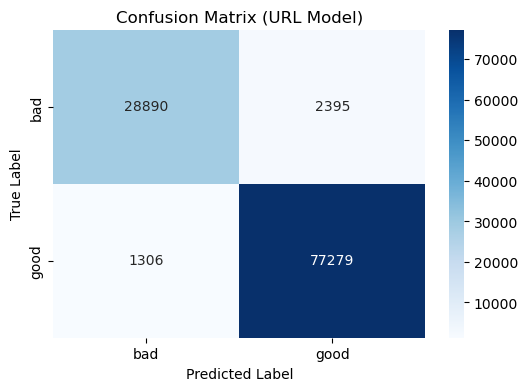

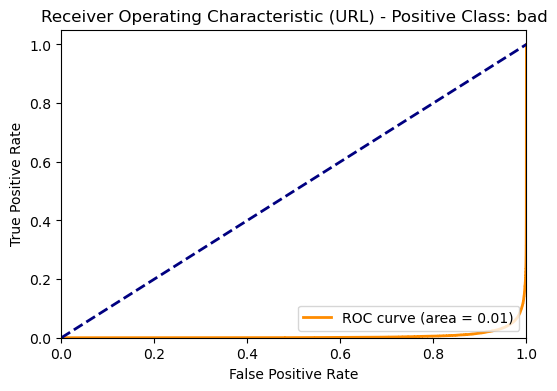

In [6]:
if 'url_model' in locals() and 'X_test_u' in locals():
    # We need to vectorize the text data first
    # Note: This might take a moment
    print("Vectorizing test set (this may take a few seconds)...")
    X_test_tfidf = url_vectorizer.transform(X_test_u)
    
    # Predict
    y_pred_u = url_model.predict(X_test_tfidf)
    y_prob_u = url_model.predict_proba(X_test_tfidf)[:, 1]

    # Convert string labels to binary for ROC/Confusion Matrix if needed
    # Assuming 'good' = 0, 'bad' = 1 or similar. Check unique values.
    unique_labels = sorted(y_test_u.unique())
    print(f"Labels found: {unique_labels}")
    
    # Map labels to 0/1 for plotting (assuming 'bad' is the positive class)
    # Adjust based on your dataset labels (e.g. 'bad', 'good')
    pos_label = 'bad' if 'bad' in unique_labels else 1
    
    # 1. Confusion Matrix
    cm_u = confusion_matrix(y_test_u, y_pred_u)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_u, annot=True, fmt='d', cmap='Blues', 
                xticklabels=unique_labels, 
                yticklabels=unique_labels)
    plt.title('Confusion Matrix (URL Model)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # 2. ROC Curve
    # Convert y_test_u to binary for ROC
    y_test_bin = (y_test_u == pos_label).astype(int)
    
    fpr, tpr, _ = roc_curve(y_test_bin, y_prob_u)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (URL) - Positive Class: {pos_label}')
    plt.legend(loc="lower right")
    plt.show()

## 3. Predicted vs Actual & Confidence

Generating Email Model Additional Graphs...


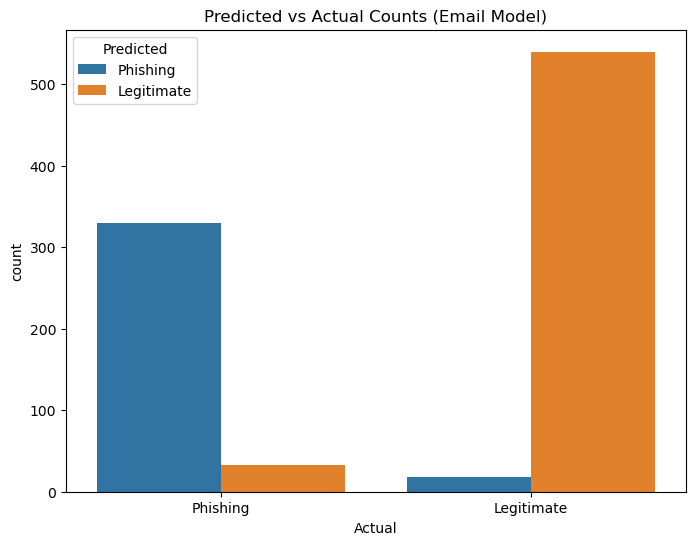

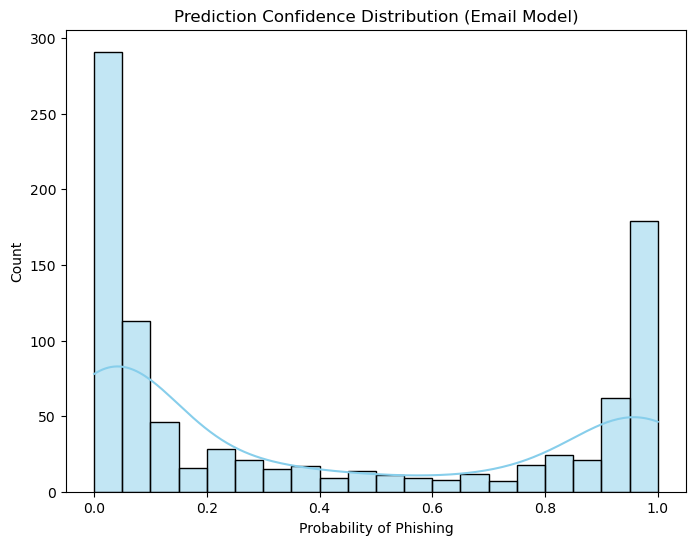

In [7]:
# Email Model Additional Graphs
print("Generating Email Model Additional Graphs...")
if 'y_test_e' in locals() and 'y_pred_e' in locals() and 'y_prob_e' in locals():
    # Predicted vs Actual Counts
    plt.figure(figsize=(8, 6))
    df_compare_e = pd.DataFrame({'Actual': y_test_e, 'Predicted': y_pred_e})
    # Map 0/1 to labels if they are numeric
    if np.issubdtype(df_compare_e['Actual'].dtype, np.number):
        df_compare_e['Actual'] = df_compare_e['Actual'].map({0: 'Legitimate', 1: 'Phishing'})
        df_compare_e['Predicted'] = df_compare_e['Predicted'].map({0: 'Legitimate', 1: 'Phishing'})

    sns.countplot(x='Actual', hue='Predicted', data=df_compare_e)
    plt.title('Predicted vs Actual Counts (Email Model)')
    plt.show()

    # Confidence Histogram
    plt.figure(figsize=(8, 6))
    sns.histplot(y_prob_e, bins=20, kde=True, color='skyblue')
    plt.title('Prediction Confidence Distribution (Email Model)')
    plt.xlabel('Probability of Phishing')
    plt.show()
else:
    print("Email model data not found in local variables.")

Generating URL Model Additional Graphs...


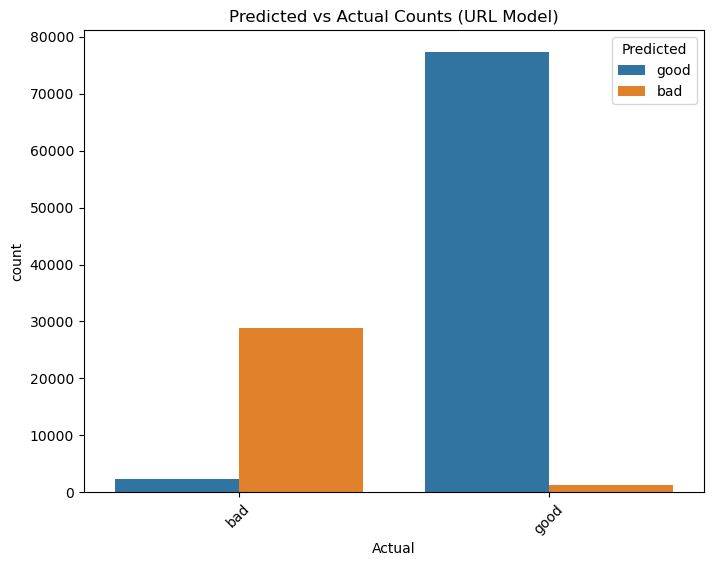

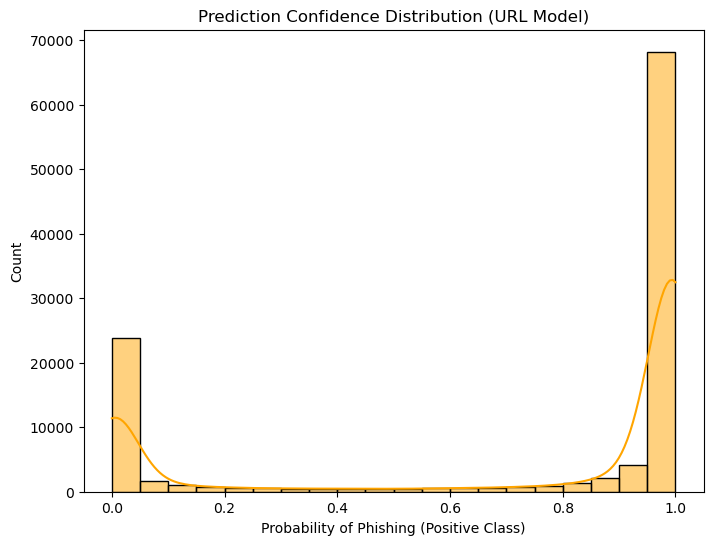

In [8]:
# URL Model Additional Graphs
print("Generating URL Model Additional Graphs...")
if 'y_test_u' in locals() and 'y_pred_u' in locals() and 'y_prob_u' in locals():
    plt.figure(figsize=(8, 6))
    df_compare_u = pd.DataFrame({'Actual': y_test_u, 'Predicted': y_pred_u})
    
    sns.countplot(x='Actual', hue='Predicted', data=df_compare_u)
    plt.title('Predicted vs Actual Counts (URL Model)')
    plt.xticks(rotation=45)
    plt.show()

    # Confidence Histogram
    plt.figure(figsize=(8, 6))
    sns.histplot(y_prob_u, bins=20, kde=True, color='orange')
    plt.title('Prediction Confidence Distribution (URL Model)')
    plt.xlabel('Probability of Phishing (Positive Class)')
    plt.show()
else:
    print("URL model data not found in local variables.")